# GB1 analysis 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import evoVAE.utils.seq_tools as st
import numpy as np
import logomaker as lm
import evoVAE.utils.statistics as stats
from matplotlib.patches import Patch
from scipy.stats import wasserstein_distance

%matplotlib inline

In [4]:
meta = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_substitutions.csv")
print(meta.columns)
meta[meta["DMS_id"] == "SPG1_STRSG_Wu_2016"]["target_seq"].values[0]

Index(['DMS_id', 'DMS_filename', 'UniProt_ID', 'taxon', 'source_organism',
       'target_seq', 'seq_len', 'includes_multiple_mutants',
       'DMS_total_number_mutants', 'DMS_number_single_mutants',
       'DMS_number_multiple_mutants', 'DMS_binarization_cutoff',
       'DMS_binarization_method', 'first_author', 'title', 'year', 'jo',
       'region_mutated', 'molecule_name', 'selection_assay', 'selection_type',
       'MSA_filename', 'MSA_start', 'MSA_end', 'MSA_len', 'MSA_bitscore',
       'MSA_theta', 'MSA_num_seqs', 'MSA_perc_cov', 'MSA_num_cov', 'MSA_N_eff',
       'MSA_Neff_L', 'MSA_Neff_L_category', 'MSA_num_significant',
       'MSA_num_significant_L', 'raw_DMS_filename', 'raw_DMS_phenotype_name',
       'raw_DMS_directionality', 'raw_DMS_mutant_column', 'weight_file_name',
       'pdb_file', 'ProteinGym_version', 'raw_mut_offset',
       'coarse_selection_type'],
      dtype='object')


'MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRNGGELTNLLGNSETTLALRNEESATADLTAAAVADTVAAAAAENAGAAAWEAAAAADALAKAKADALKEFNKYGVSDYYKNLINNAKTVEGIKDLQAQVVESAKKARISEATDGLSDFLKSQTPAEDTVKSIELAEAKVLANRELDKYGVSDYHKNLINNAKTVEGVKELIDEILAALPKTDQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTEKPEVIDASELTPAVTTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTYDDATKTFTVTEMVTEVPGDAPTEPEKPEASIPLVPLTPATPIAKDDAKKDDTKKEDAKKPEAKKDDAKKAETLPTTGEGSNPFFTAAALAVMAGAGALAVASKRKED'

In [3]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/alns/"
#gb1_a = pd.read_pickle(path + "gb1_ancestors_no_dupes.pkl")
gb1_ae = pd.read_pickle(path + "gb1_ancestors_extants_no_dupes.pkl")
#gb1_e = pd.read_pickle(path + "gb1_extants_no_dupes.pkl")

In [5]:
numpy_aln, _, _ = st.convert_msa_numpy_array(gb1_ae)
seq_sim = st.reweight_by_seq_similarity(numpy_aln, 0.2)
pos_sim = st.position_based_seq_weighting(numpy_aln, 4)

gb1_ae["seq_sim"] = seq_sim
gb1_ae["pos_sim"] = pos_sim

gb1_ae

Sequence weight numpy array created with shape (num_seqs, columns):  (14276, 448)


,id,sequence,seq_sim,pos_sim
0,N0_gb1_tree_1,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.021277,0.000113
1,N1_gb1_tree_1,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.020833,0.000113
3,N3_gb1_tree_1,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.020833,0.000113
6,N6_gb1_tree_1,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.020833,0.000113
7,N7_gb1_tree_1,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTTVAADSAIEDTPIIRN...,0.020408,0.000097
...,...,...,...,...
46202,UniRef100_UPI000768A238/12-386,----------------------ASVALGAGVASQPTVVRAEEA---...,0.006289,0.000046
46205,UniRef100_UPI001959AF38/4-600,-------KFSIRKLAVGVVSVSIGITGLSTISTDNITFANTHTVS-...,1.000000,0.001823
46208,UniRef100_UPI000765255D/5-423,-KSERKVHYSIRKFSIGVASVVVASLFLGGVVHAEGVRSKNNLTVT...,0.076923,0.000158
46229,UniRef100_UPI001454C06F/5-327,-KSERKVHYSIRKFSIGVASVVVASLVMGSVVHATEKEGITPVATS...,0.043478,0.000135


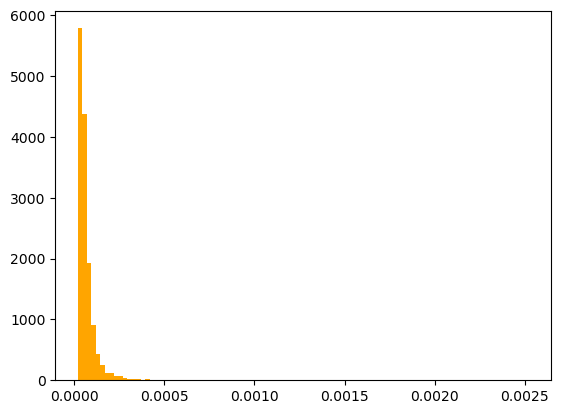

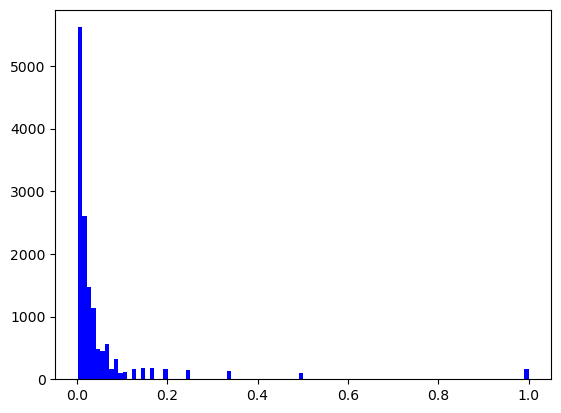

In [18]:
plt.hist(gb1_ae["pos_sim"], color="orange", alpha=1, bins=100)

plt.show()

plt.hist(gb1_ae["seq_sim"], color="blue", alpha=1, bins=100)
plt.show()

The following residues were modified
V39, 
D40
G41 
V54

They all lie within 15 residues of each other 

The distribution of data is very skewed though
"While most mutants had a lower fitness compared to WT (fitness < 1), 2.4% of mutants were beneficial (fitness > 1)."

In [5]:
gb1_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/SPG1_STRSG_Wu_2016.csv")
gb1_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,D266A,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,2.401243,1
1,D266A:G267A,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.259549,1
2,D266A:G267A:V280A,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,6.201135,1
3,D266A:G267A:V280C,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,2.705083,1
4,D266A:G267A:V280E,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.004726,0


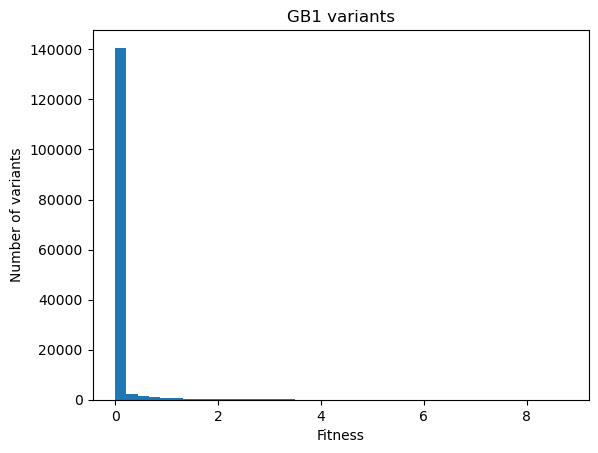

In [6]:
gb1_variants["DMS_score"].describe()

plt.hist(gb1_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("GB1 variants")
plt.show()

In [11]:
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/alns/"
gb1_e = pd.read_pickle(aln_path + "gb1_extants_no_dupes.pkl")
gb1_a = pd.read_pickle(aln_path + "gb1_ancestors_no_dupes.pkl")

gb1_extant_seqs = [x for x in gb1_e["sequence"]]
gb1_ancestor_seqs = [x for x in gb1_a["sequence"]]

data = [gb1_extant_seqs, gb1_ancestor_seqs]
labels = ["GB1 extant MSA", "GB1 ancestor MSA"]

In [25]:
#convert to numpy form for quick processing
gb1_e_col_entropy = stats.calc_shannon_entropy(gb1_e) 
gb1_a_col_entropy = stats.calc_shannon_entropy(gb1_a)

Sequence weight numpy array created with shape (num_seqs, columns):  (2286, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (12733, 448)


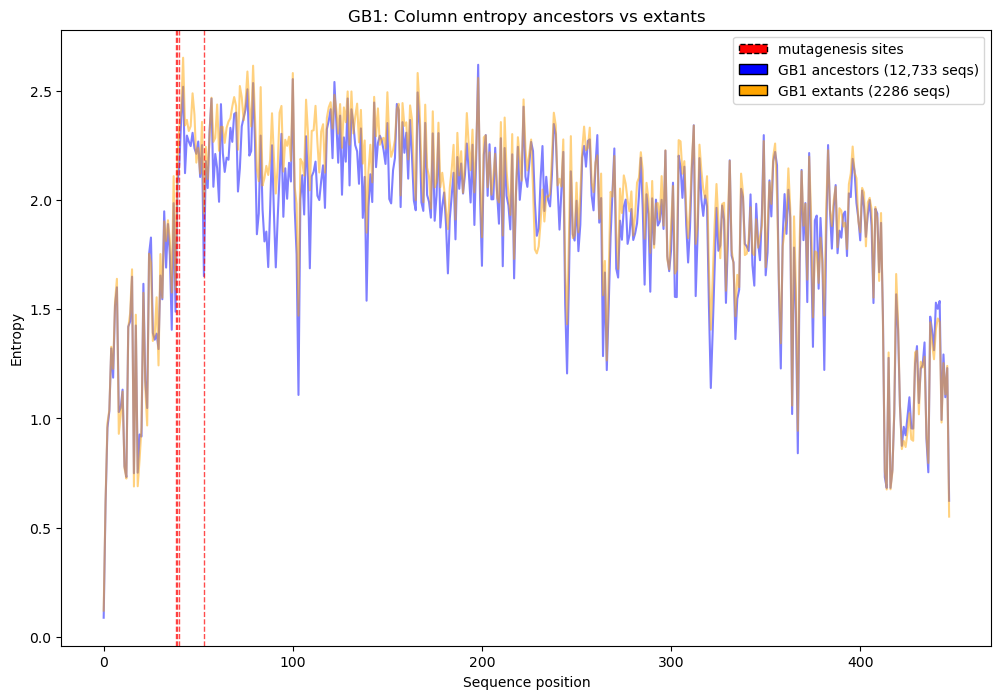

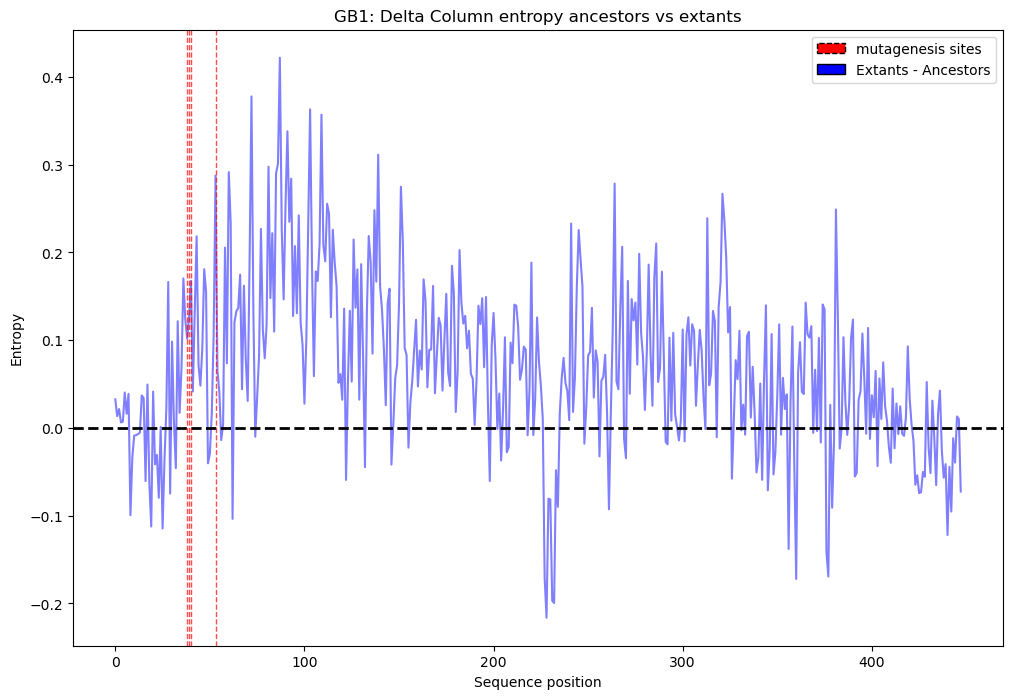

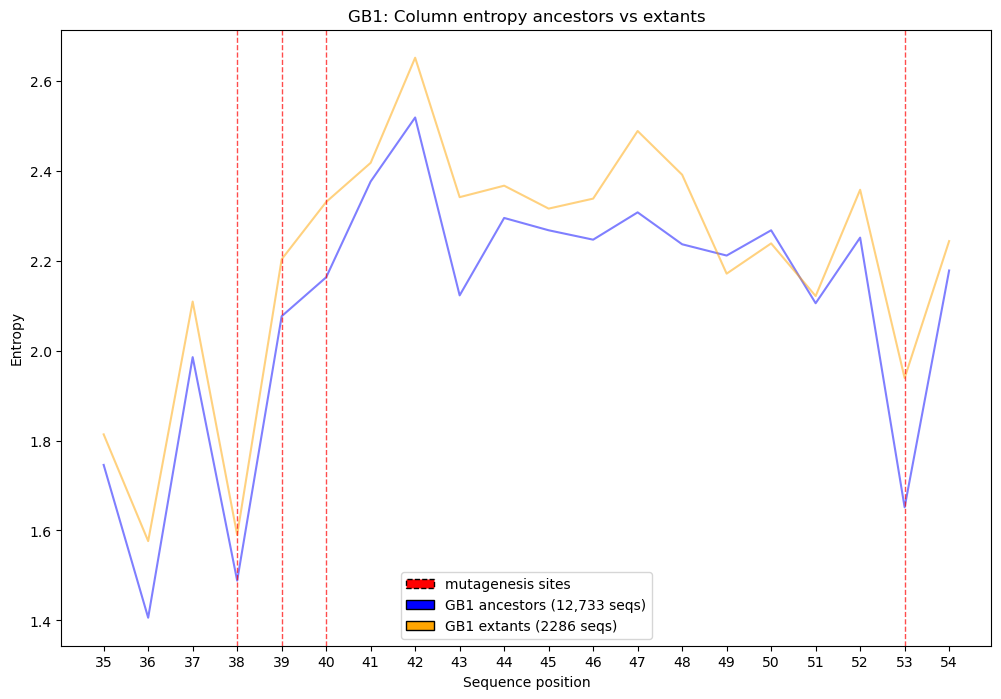

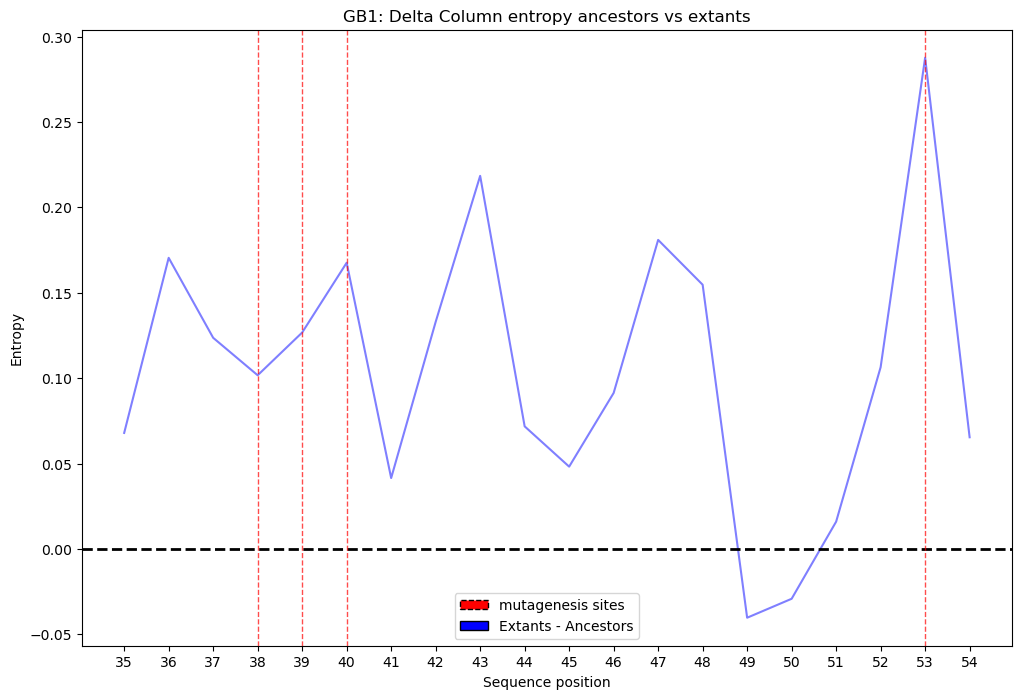

In [121]:

# across entire sequnece 
xticks = range(0, len(gb1_e_col_entropy))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, gb1_a_col_entropy, alpha=0.5,  color='blue')
plt.plot(xticks, gb1_e_col_entropy, alpha=0.5, color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',label="GB1 ancestors (12,733 seqs)"),
    Patch(facecolor='orange', edgecolor='black', label="GB1 extants (2286 seqs)"),
]

plt.legend(handles=legend_elements,)

mutations = [38, 39, 40, 53]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("GB1: Column entropy ancestors vs extants")
plt.show()

# Delta elbo across entire sequnece 
xticks = range(0, len(gb1_e_col_entropy))
delta_col_h = gb1_e_col_entropy - gb1_a_col_entropy

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=0.5, label="GB1 ancestors (12,733 seqs)", color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")

plt.axhline(y=0, color='black', linestyle='--', linewidth=2)


legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),
]

plt.legend(handles=legend_elements,)

mutations = [38, 39, 40, 53]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("GB1: Delta Column entropy ancestors vs extants")
plt.show()


# now just across the mutation sites 
xticks = range(35, 55)

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, gb1_a_col_entropy[35:55], alpha=0.5, label="GB1 ancestors (12,733 seqs)", color='blue')
plt.plot(xticks, gb1_e_col_entropy[35:55], alpha=0.5, label="GB1 extants (2286 seqs)", color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',label="GB1 ancestors (12,733 seqs)"),
    Patch(facecolor='orange', edgecolor='black', label="GB1 extants (2286 seqs)"),
]


plt.xticks(ticks=xticks, labels=xticks)
plt.legend(handles=legend_elements,)

mutations = [38, 39, 40, 53]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("GB1: Column entropy ancestors vs extants")
plt.show()

# Delta elbo across subset of sequnece 
xticks = range(35, 55)
delta_col_h = (gb1_e_col_entropy - gb1_a_col_entropy)[35:55]

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=0.5, label="GB1 ancestors (12,733 seqs)", color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")

plt.xticks(ticks=xticks, labels=xticks)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)


legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),
]

plt.legend(handles=legend_elements,)

mutations = [38, 39, 40, 53]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("GB1: Delta Column entropy ancestors vs extants")
plt.show()



#### GB1 - Wasserstein distance 

In [3]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/alns/"
gb1_a = pd.read_pickle(path + "gb1_ancestors_no_dupes.pkl")
gb1_ae = pd.read_pickle(path + "gb1_ancestors_extants_no_dupes.pkl")
gb1_e = pd.read_pickle(path + "gb1_extants_no_dupes.pkl")

In [56]:
gb1_e.head()

,id,sequence
0,SPG1_STRSG/1-448,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
1,UniRef100_Q93EM8/1-351,MEKEKKVKYFLRKSAFGLASVSAAFLVSGALENTITVSAE--TIPA...
2,UniRef100_Q53975/1-351,MEKEKKVKYFLRKSAFGLASVSAAFLVSGALENTITVSAE--TIPA...
3,UniRef100_A0A509DAN6/1-448,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
4,UniRef100_A0A448DI38/1-351,MEKEKKMKYFLRKSAFGLASVSAAFLVGTTLDTTMTVSAEPAGIIA...


In [4]:
gb1_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/SPG1_STRSG_Wu_2016.csv")
gb1_variants = gb1_variants.rename(columns={"mutated_sequence": "sequence", "mutant": "id"})

In [62]:
gb1_variants

,id,sequence,DMS_score,DMS_score_bin
0,D266A,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,2.401243,1
1,D266A:G267A,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.259549,1
2,D266A:G267A:V280A,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,6.201135,1
3,D266A:G267A:V280C,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,2.705083,1
4,D266A:G267A:V280E,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.004726,0
...,...,...,...,...
149355,V280R,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.006168,0
149356,V280S,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.495760,1
149357,V280T,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.615189,1
149358,V280W,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.699995,1


Sequence weight numpy array created with shape (num_seqs, columns):  (12733, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (2286, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (14276, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (149360, 448)
Dist A-E: 0.5723476482787782
Dist A-AE: 0.06189802838018126
Dist E-AE: 0.5154249919472801
Dist A-V: 5.289377921863789
Dist E-V: 5.457538960734717
Dist AE-V: 5.309562562929609


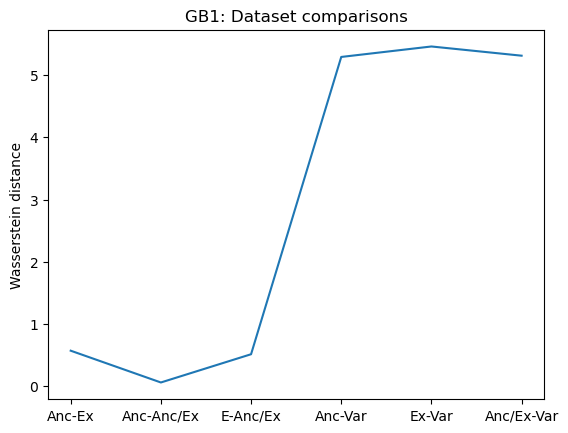

In [5]:
gb1_a_ppm = stats.calc_position_prob_matrix(gb1_a)
gb1_e_ppm = stats.calc_position_prob_matrix(gb1_e)
gb1_ae_ppm = stats.calc_position_prob_matrix(gb1_ae)
gb1_var_ppm = stats.calc_position_prob_matrix(gb1_variants)



Dist A-E: 0.5723476482787782
Dist A-AE: 0.06189802838018126
Dist E-AE: 0.5154249919472801
Dist A-V: 5.289377921863789
Dist E-V: 5.457538960734717
Dist AE-V: 5.309562562929609


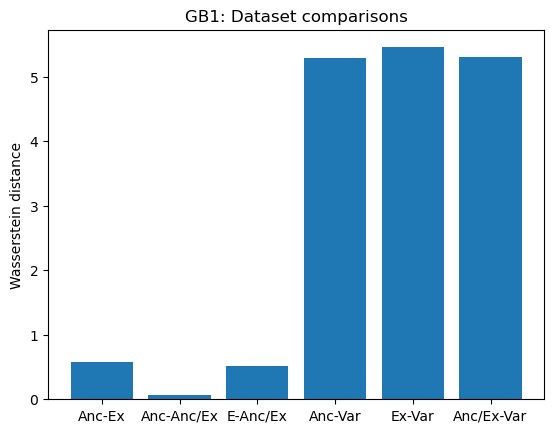

In [11]:
wd_a_to_e = []
wd_a_to_ae = []
wd_e_to_ae = []
wd_a_to_v = []
wd_e_to_v = []
wd_ae_to_v = []

for i in range(gb1_a_ppm.shape[1]):
    col_a_i = gb1_a_ppm[:, i]
    col_e_i = gb1_e_ppm[:, i]
    col_ae_i = gb1_ae_ppm[:, i]
    col_v_i = gb1_var_ppm[:, i]
    
    wd_a_to_e.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)),col_a_i, col_e_i))
    wd_a_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_a_i, col_ae_i))
    wd_e_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_ae_i))

    wd_a_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)), col_a_i, col_v_i))
    wd_e_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_v_i)) 
    wd_ae_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_ae_i, col_v_i))

print(f"Dist A-E: {np.mean(wd_a_to_e)}")
print(f"Dist A-AE: {np.mean(wd_a_to_ae)}")
print(f"Dist E-AE: {np.mean(wd_e_to_ae)}")

print(f"Dist A-V: {np.mean(wd_a_to_v)}")
print(f"Dist E-V: {np.mean(wd_e_to_v)}")
print(f"Dist AE-V: {np.mean(wd_ae_to_v)}")


plt.bar(np.arange(6), [np.mean(wd_a_to_e), np.mean(wd_a_to_ae), np.mean(wd_e_to_ae), np.mean(wd_a_to_v), np.mean(wd_e_to_v), np.mean(wd_ae_to_v)])
plt.title("GB1: Dataset comparisons")
plt.ylabel("Wasserstein distance")
plt.xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], )
plt.show()

In [35]:
gb1_a_ppm.flatten().shape

(9408,)

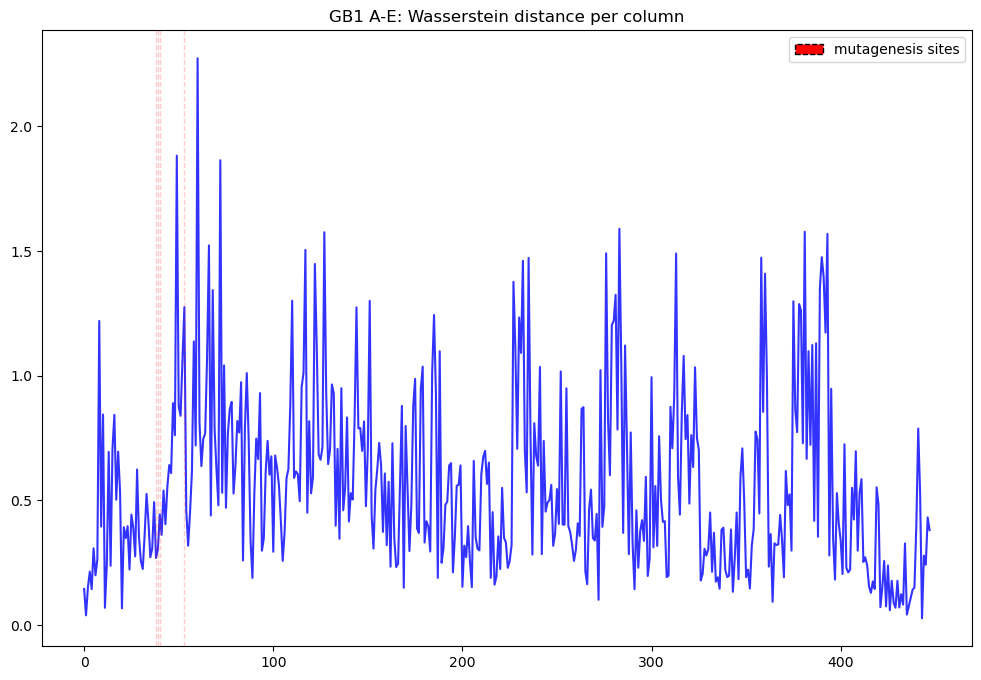

In [51]:
# across entire sequnece 
xticks = range(0, len(wd_a_to_e))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, wd_a_to_e, alpha=0.8, color='blue')
mutations = [38, 39, 40, 53]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.2)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
]

plt.legend(handles=legend_elements,)

plt.title("GB1 A-E: Wasserstein distance per column")
plt.show()

# GFP 

In [62]:
gfp_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GFP_AEQVI_Sarkisyan_2016.csv")
gfp_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,K3R:V55A:Q94R:A110T:D117G:M153K:D216A,MSRGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1.301030,0
1,K3Q:V16A:I167T:L195Q,MSQGEELFTGVVPILAELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.137350,1
2,K3Q:Y143C:N164D:S205P:A227T,MSQGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1.553913,0
3,K3Q:Y143N:V193A,MSQGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.404237,1
4,K3R,MSRGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.738586,1


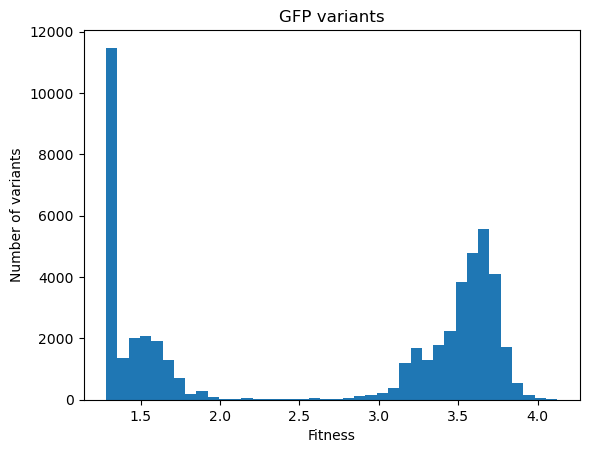

In [63]:
plt.hist(gfp_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("GFP variants")
plt.show()

In [66]:
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gfp_alns/independent_runs/no_synthetic/alns/"
gfp_e = pd.read_pickle(aln_path + "gfp_extants_no_syn_no_dupes.pkl")
gfp_a = pd.read_pickle(aln_path + "gfp_ancestors_no_syn_no_dupes.pkl")

gfp_extant_seqs = [x for x in gfp_e["sequence"]]
gfp_ancestor_seqs = [x for x in gfp_a["sequence"]]

data = [gfp_extant_seqs, gfp_ancestor_seqs]
labels = ["GFP extant MSA", "GFP ancestor MSA"]

In [67]:
#convert to numpy form for quick processing
gfp_e_col_entropy = stats.calc_shannon_entropy(gfp_e) 
gfp_a_col_entropy = stats.calc_shannon_entropy(gfp_a)

Sequence weight numpy array created with shape (num_seqs, columns):  (324, 238)
Sequence weight numpy array created with shape (num_seqs, columns):  (497, 238)


In [143]:
gfp_muts = set()

for x in gfp_variants["mutant"]:
    data = x.split(":")
    for z in data:
        gfp_muts.add(z[1:-1])
print(len(gfp_muts))
print(min(gfp_muts), max(gfp_muts))

233
10 99


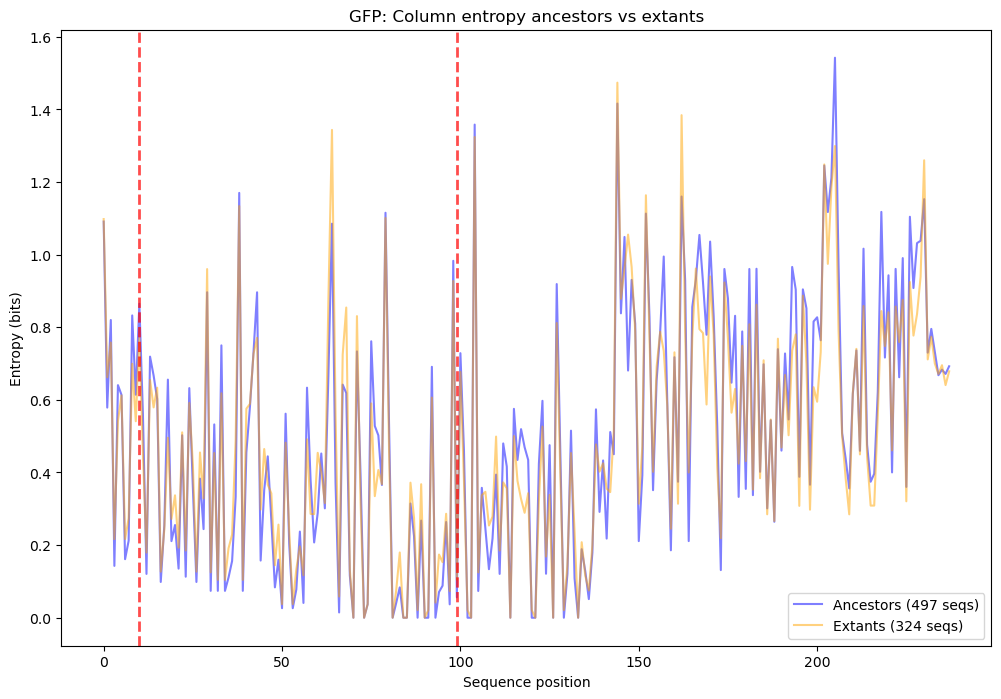

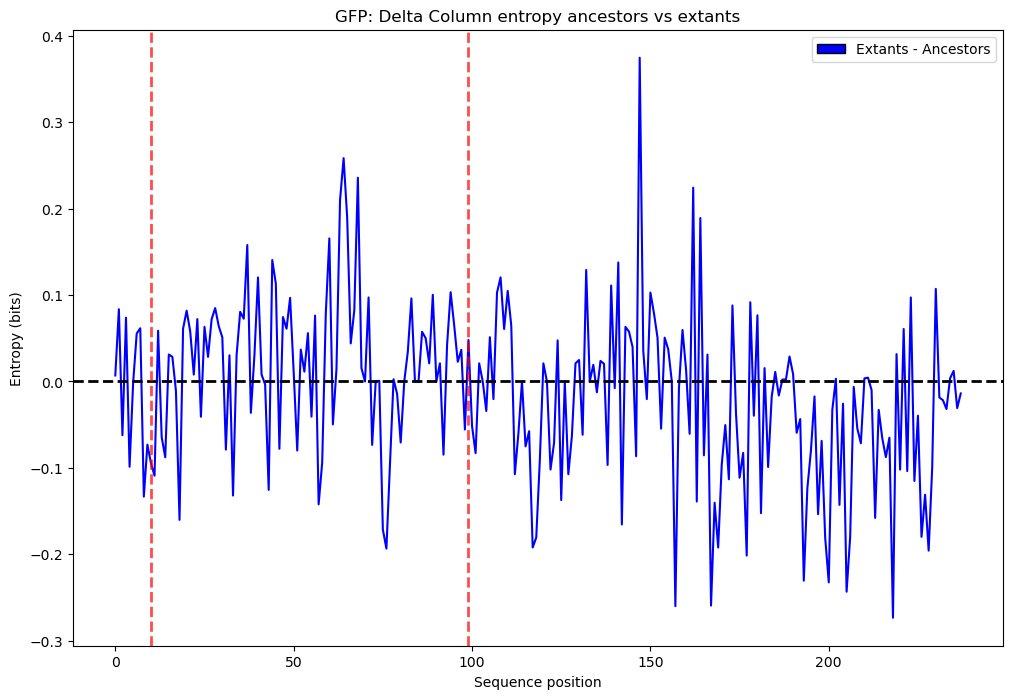

In [146]:

# across entire sequnece 
xticks = range(0, len(gfp_e_col_entropy))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, gfp_a_col_entropy, alpha=0.5, label="Ancestors (497 seqs)", color='blue')
plt.plot(xticks, gfp_e_col_entropy, alpha=0.5, label="Extants (324 seqs)", color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")

mutations = [10, 99]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=2, alpha=0.7)

plt.legend()

plt.title("GFP: Column entropy ancestors vs extants")
plt.show()

# Delta elbo across entire sequnece 
xticks = range(0, len(gfp_e_col_entropy))
delta_col_h = gfp_e_col_entropy - gfp_a_col_entropy

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=1, label="Delta entropy (Extants - Ancestors)", color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")

plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

legend_elements = [
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),
]

for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=2, alpha=0.7)


plt.legend(handles=legend_elements,)

plt.title("GFP: Delta Column entropy ancestors vs extants")
plt.show()





##### GFP - Wasserstein distance 

In [43]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/gfp/independent_runs/no_synthetic/alns/"
gfp_a = pd.read_pickle(path + "gfp_ancestors_no_syn_no_dupes.pkl")
gfp_ae = pd.read_pickle(path + "gfp_ancestors_extants_no_syn_no_dupes.pkl")
gfp_e = pd.read_pickle(path + "gfp_extants_no_syn_no_dupes.pkl")

In [45]:
gfp_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GFP_AEQVI_Sarkisyan_2016.csv")
gfp_variants = gfp_variants.rename(columns={"mutated_sequence": "sequence", "mutant": "id"})

In [46]:
gfp_variants.head()

,id,sequence,DMS_score,DMS_score_bin
0,K3R:V55A:Q94R:A110T:D117G:M153K:D216A,MSRGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1.301030,0
1,K3Q:V16A:I167T:L195Q,MSQGEELFTGVVPILAELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.137350,1
2,K3Q:Y143C:N164D:S205P:A227T,MSQGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1.553913,0
3,K3Q:Y143N:V193A,MSQGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.404237,1
4,K3R,MSRGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.738586,1


Sequence weight numpy array created with shape (num_seqs, columns):  (497, 238)
Sequence weight numpy array created with shape (num_seqs, columns):  (324, 238)
Sequence weight numpy array created with shape (num_seqs, columns):  (673, 238)
Sequence weight numpy array created with shape (num_seqs, columns):  (51714, 238)
Dist A-E: 0.2759415972961954
Dist A-AE: 0.06325623399643425
Dist E-AE: 0.22453658421158343
Dist A-V: 0.9283286071308591
Dist E-V: 0.8032552909782081
Dist AE-V: 0.9213718999208078


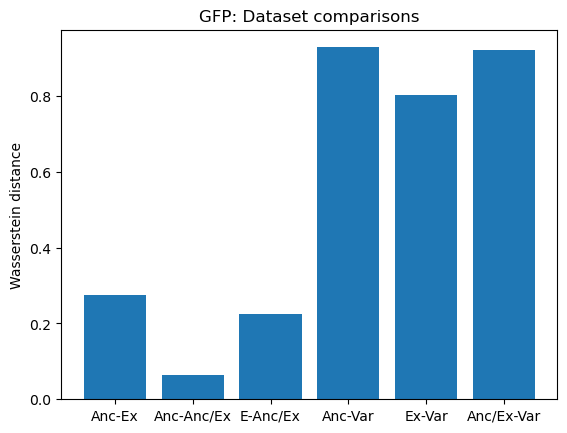

In [49]:
gfp_a_ppm = stats.calc_position_prob_matrix(gfp_a)
gfp_e_ppm = stats.calc_position_prob_matrix(gfp_e)
gfp_ae_ppm = stats.calc_position_prob_matrix(gfp_ae)
gfp_var_ppm = stats.calc_position_prob_matrix(gfp_variants)

wd_a_to_e = []
wd_a_to_ae = []
wd_e_to_ae = []
wd_a_to_v = []
wd_e_to_v = []
wd_ae_to_v = []

for i in range(gfp_a_ppm.shape[1]):
    col_a_i = gfp_a_ppm[:, i]
    col_e_i = gfp_e_ppm[:, i]
    col_ae_i = gfp_ae_ppm[:, i]
    col_v_i = gfp_var_ppm[:, i]
    
    wd_a_to_e.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)),col_a_i, col_e_i))
    wd_a_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_a_i, col_ae_i))
    wd_e_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_ae_i))

    wd_a_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)), col_a_i, col_v_i))
    wd_e_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_v_i)) 
    wd_ae_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_ae_i, col_v_i))

print(f"Dist A-E: {np.mean(wd_a_to_e)}")
print(f"Dist A-AE: {np.mean(wd_a_to_ae)}")
print(f"Dist E-AE: {np.mean(wd_e_to_ae)}")

print(f"Dist A-V: {np.mean(wd_a_to_v)}")
print(f"Dist E-V: {np.mean(wd_e_to_v)}")
print(f"Dist AE-V: {np.mean(wd_ae_to_v)}")

plt.bar(np.arange(6), [np.mean(wd_a_to_e), np.mean(wd_a_to_ae), np.mean(wd_e_to_ae), np.mean(wd_a_to_v), np.mean(wd_e_to_v), np.mean(wd_ae_to_v)])
plt.title("GFP: Dataset comparisons")
plt.ylabel("Wasserstein distance")
plt.xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], )
plt.show()

# A4 

In [76]:
#672-713 (673) /Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns A4_HUMAN_Seuma_2022

a4_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/A4_HUMAN_Seuma_2022.csv")
a4_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,A673C,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-1.018869,1
1,A673D,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-0.605052,1
2,A673E,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-0.590857,1
3,A673E:A692E,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-2.443601,0
4,A673E:A692T,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-3.049893,0


In [99]:
# all the mutation positoins will be here 
a4_muts = set()

for x in a4_variants["mutant"]:
    data = x.split(":")
    a = data[0][1:-1]
    a4_muts.add(a)
    if len(data) == 2:
        b = data[1][1:-1]
        a4_muts.add(b)
len(a4_muts)
print(min(a4_muts), max(a4_muts))

672 713


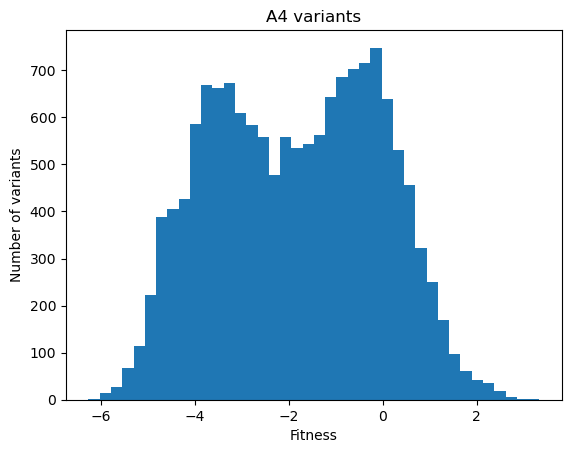

In [78]:
a4_variants["DMS_score"].describe()

plt.hist(a4_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("A4 variants")
plt.show()

In [79]:
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/"
a4_e = pd.read_pickle(aln_path + "a4_extants_no_dupes.pkl")
a4_a = pd.read_pickle(aln_path + "a4_ancestors_no_dupes.pkl")

a4_extant_seqs = [x for x in a4_e["sequence"]]
a4_ancestor_seqs = [x for x in a4_a["sequence"]]

data = [gb1_extant_seqs, gb1_ancestor_seqs]
labels = ["A4 extant MSA", "A4 ancestor MSA"]

In [80]:
#convert to numpy form for quick processing
a4_e_col_entropy = stats.calc_shannon_entropy(a4_e) 
a4_a_col_entropy = stats.calc_shannon_entropy(a4_a)

Sequence weight numpy array created with shape (num_seqs, columns):  (4936, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (29940, 770)


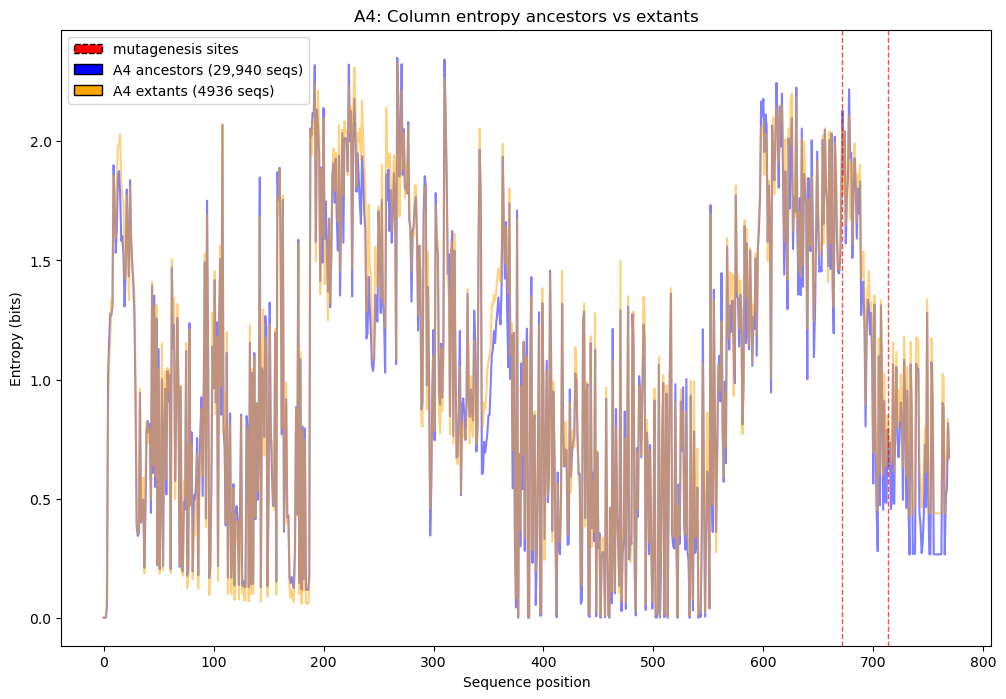

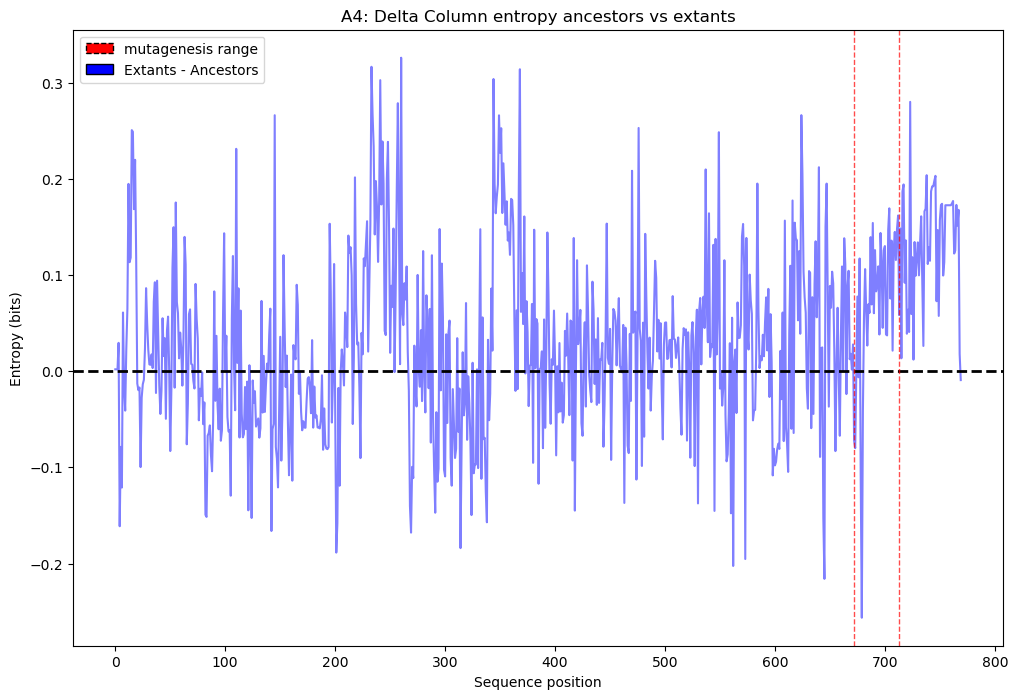

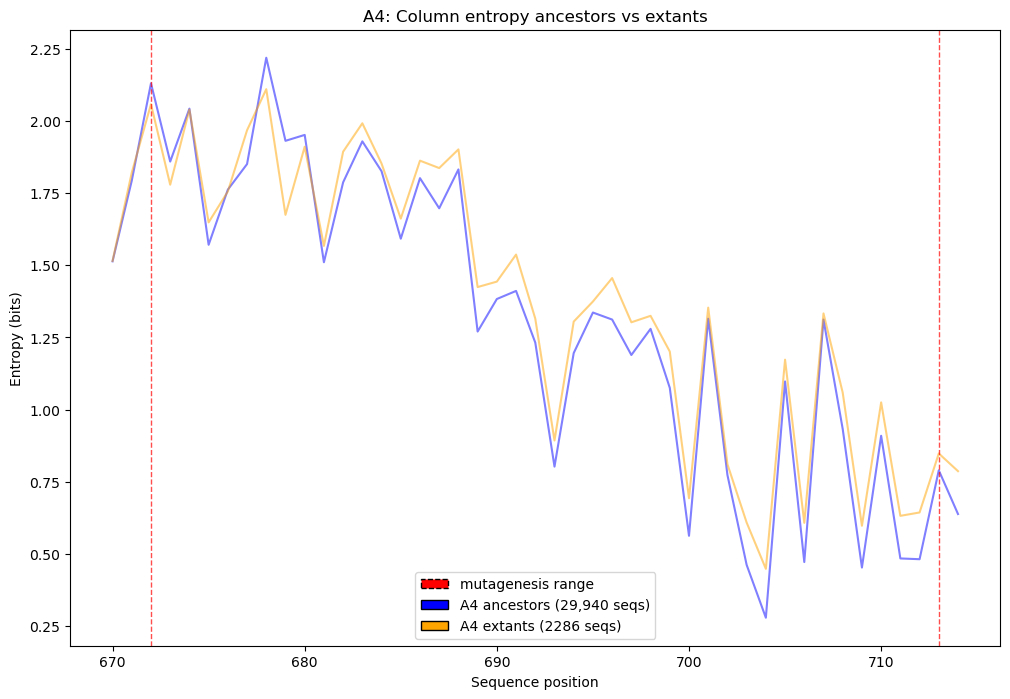

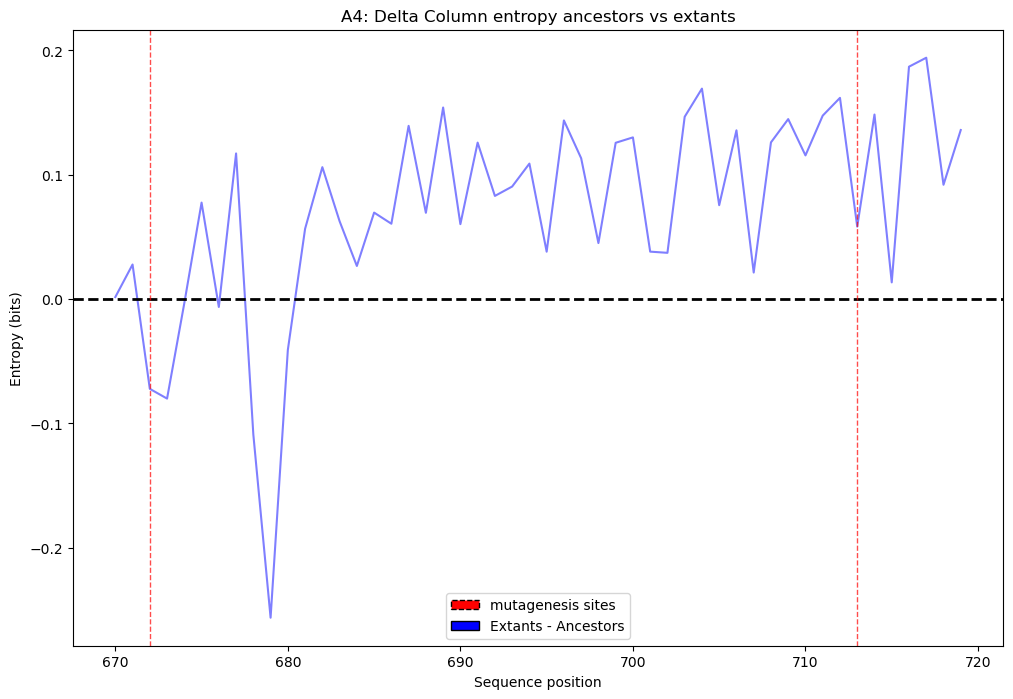

In [139]:

# across entire sequnece 
xticks = range(0, len(a4_e_col_entropy))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, a4_a_col_entropy, alpha=0.5, label="A4 ancestors (29,940 seqs)", color='blue')
plt.plot(xticks, a4_e_col_entropy, alpha=0.5, label="A4 extants (4936 seqs)", color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black', label='A4 ancestors (29,940 seqs)'),
    Patch(facecolor='orange', edgecolor='black', label='A4 extants (4936 seqs)'),
]

plt.legend(handles=legend_elements,)

mutations = [672, 713]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("A4: Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# Delta elbo across entire sequnece 
xticks = range(0, len(a4_e_col_entropy))
delta_col_h = a4_e_col_entropy - a4_a_col_entropy

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=0.5, color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")

plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis range'),
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),
]

plt.legend(handles=legend_elements,)

mutations = [672, 713]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("A4: Delta Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# now just across the mutation sites 
xticks = range(670, 715)

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, a4_a_col_entropy[670:715], alpha=0.5, label="A4 ancestors (12,733 seqs)", color='blue')
plt.plot(xticks, a4_e_col_entropy[670:715], alpha=0.5, label="A4 extants (2286 seqs)", color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")



legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis range'),
    Patch(facecolor='blue', edgecolor='black', label='A4 ancestors (29,940 seqs)'),
    Patch(facecolor='orange', edgecolor='black', label='A4 extants (2286 seqs)'),
]


#plt.xticks(ticks=xticks, labels=xticks)
plt.legend(handles=legend_elements,)

mutations = [672, 713]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("A4: Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# Delta elbo across subset of sequnece 
xticks = range(670, 720)
delta_col_h = (a4_e_col_entropy - a4_a_col_entropy)[670:720]

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=0.5, label="A4 ancestors (12,733 seqs)", color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")

#plt.xticks(ticks=xticks, labels=xticks)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),

]

plt.legend(handles=legend_elements,)

mutations = [672, 713]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("A4: Delta Column entropy ancestors vs extants")
plt.show()



#### A4 - Wasserstein distance

In [51]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/"
a4_a = pd.read_pickle(path + "a4_ancestors_no_dupes.pkl")
a4_ae = pd.read_pickle(path + "a4_ancestors_extants_no_dupes.pkl")
a4_e = pd.read_pickle(path + "a4_extants_no_dupes.pkl")

In [53]:
a4_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/A4_HUMAN_Seuma_2022.csv")
a4_variants = a4_variants.rename(columns={"mutated_sequence": "sequence", "mutant": "id"})

Sequence weight numpy array created with shape (num_seqs, columns):  (29940, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (4936, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (32125, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (14811, 770)
Dist A-E: 0.4210166480071743
Dist A-AE: 0.030557751550906058
Dist E-AE: 0.3982470664809732
Dist A-V: 2.675403187327035
Dist E-V: 2.5448590168441774
Dist AE-V: 2.674009241245136


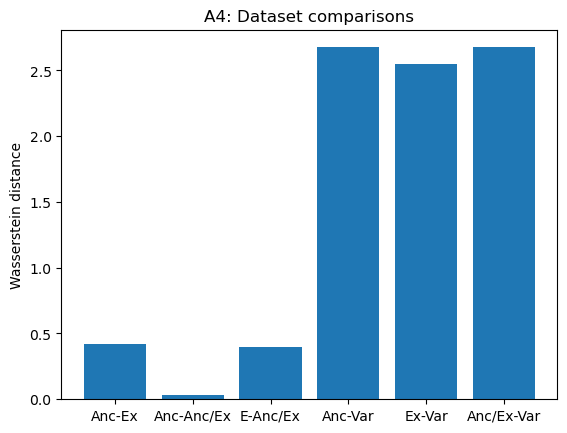

In [55]:
a4_a_ppm = stats.calc_position_prob_matrix(a4_a)
a4_e_ppm = stats.calc_position_prob_matrix(a4_e)
a4_ae_ppm = stats.calc_position_prob_matrix(a4_ae)
a4_var_ppm = stats.calc_position_prob_matrix(a4_variants)

wd_a_to_e = []
wd_a_to_ae = []
wd_e_to_ae = []
wd_a_to_v = []
wd_e_to_v = []
wd_ae_to_v = []

for i in range(gb1_a_ppm.shape[1]):
    col_a_i = a4_a_ppm[:, i]
    col_e_i = a4_e_ppm[:, i]
    col_ae_i = a4_ae_ppm[:, i]
    col_v_i = a4_var_ppm[:, i]
    
    wd_a_to_e.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)),col_a_i, col_e_i))
    wd_a_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_a_i, col_ae_i))
    wd_e_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_ae_i))

    wd_a_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)), col_a_i, col_v_i))
    wd_e_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_v_i)) 
    wd_ae_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_ae_i, col_v_i))

print(f"Dist A-E: {np.mean(wd_a_to_e)}")
print(f"Dist A-AE: {np.mean(wd_a_to_ae)}")
print(f"Dist E-AE: {np.mean(wd_e_to_ae)}")

print(f"Dist A-V: {np.mean(wd_a_to_v)}")
print(f"Dist E-V: {np.mean(wd_e_to_v)}")
print(f"Dist AE-V: {np.mean(wd_ae_to_v)}")

plt.bar(np.arange(6), [np.mean(wd_a_to_e), np.mean(wd_a_to_ae), np.mean(wd_e_to_ae), np.mean(wd_a_to_v), np.mean(wd_e_to_v), np.mean(wd_ae_to_v)])
plt.title("A4: Dataset comparisons")
plt.ylabel("Wasserstein distance")
plt.xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], )
plt.show()

# GCN4 

In [122]:
gcn4_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GCN4_YEAST_Staller_2018.csv")
gcn4_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,D103A,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.543932,1
1,D103A:F108N:K118D:S122Q:V135I:D139W,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.158042,0
2,D103A:S104T:T105I:P106T:M107L:F108T:E109S:N112...,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.391235,1
3,D103A:S122A:V130Q:T132M:S144N,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.243840,0
4,D103A:S122E:S136P:K140S:A141R,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.678492,1


In [125]:
# all the mutation positoins will be here 
gcn4_muts = set()

for x in gcn4_variants["mutant"]:
    data = x.split(":")
    for z in data:
        b = z[1:-1]
        gcn4_muts.add(b)
print(len(gcn4_muts))
print(min(gcn4_muts), max(gcn4_muts))

44
101 144


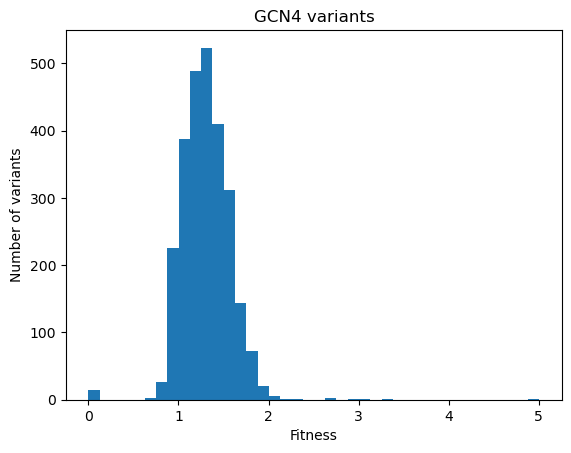

In [128]:
gcn4_variants["DMS_score"].describe()

plt.hist(gcn4_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("GCN4 variants")
plt.show()

In [129]:
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/"
gcn4_e = pd.read_pickle(aln_path + "gcn4_extants_no_dupes.pkl")
gcn4_a = pd.read_pickle(aln_path + "gcn4_ancestors_no_dupes.pkl")

a4_extant_seqs = [x for x in gcn4_e["sequence"]]
a4_ancestor_seqs = [x for x in gcn4_a["sequence"]]

data = [gb1_extant_seqs, gb1_ancestor_seqs]
labels = ["GCN4 extant MSA", "GCN4 ancestor MSA"]

In [130]:
#convert to numpy form for quick processing
gcn4_e_col_entropy = stats.calc_shannon_entropy(gcn4_e) 
gcn4_a_col_entropy = stats.calc_shannon_entropy(gcn4_a)

Sequence weight numpy array created with shape (num_seqs, columns):  (331, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (11623, 281)


In [12]:
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_extants.fasta"

gcn_all_ex = st.read_aln_file(aln_path)


Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_extants.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Performing one hot encoding
Number of seqs: 348


In [19]:
gcn_all_ex


names = []
with open("gcn4_sample.txt", 'r') as file:
    lines = file.readlines()

    for line in lines:
        line = line.strip()
        data = line.split("/")
        if len(data) >= 2:
            names.append(data[0])

In [27]:
subset = gcn_all_ex[gcn_all_ex["id"].apply(lambda x : x.split("/")[0]).isin(names)]
st.write_fasta_file("gcn4_uniprot_search.fasta", subset)

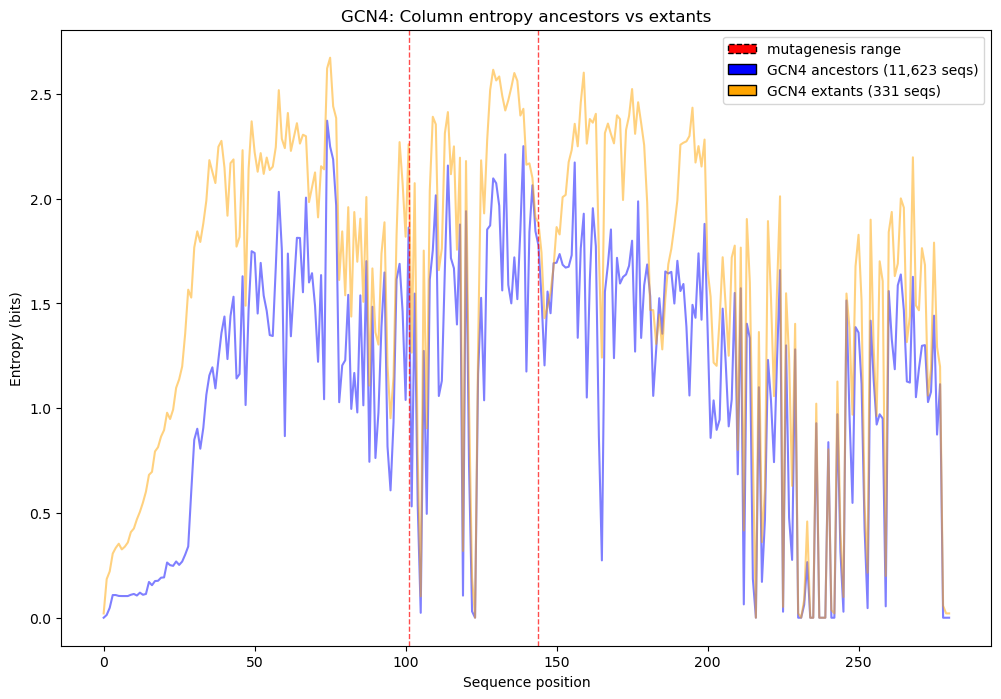

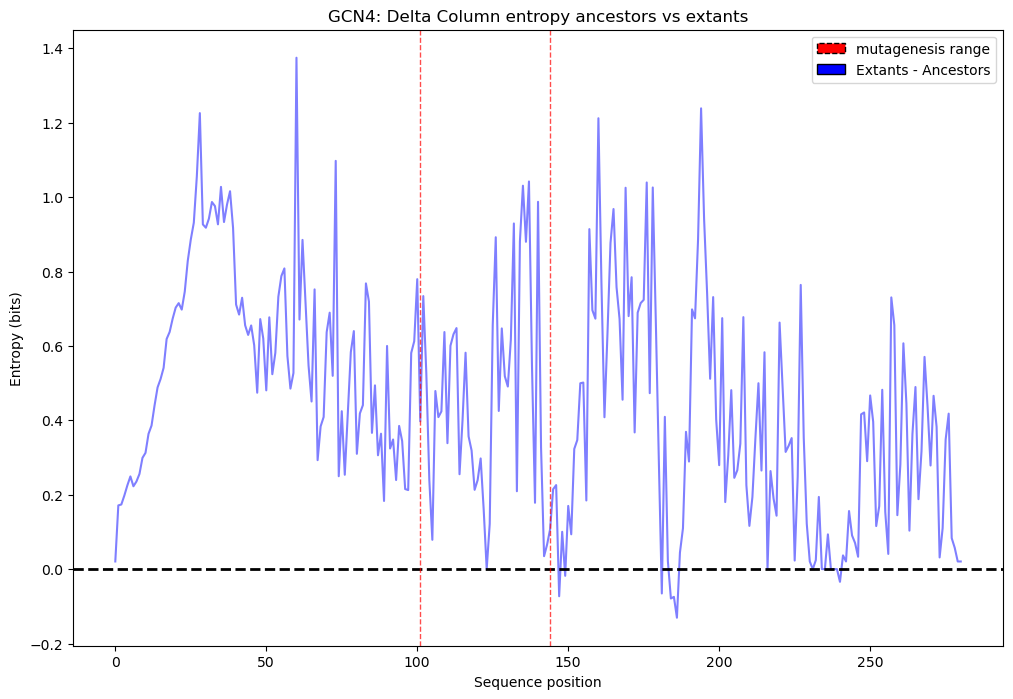

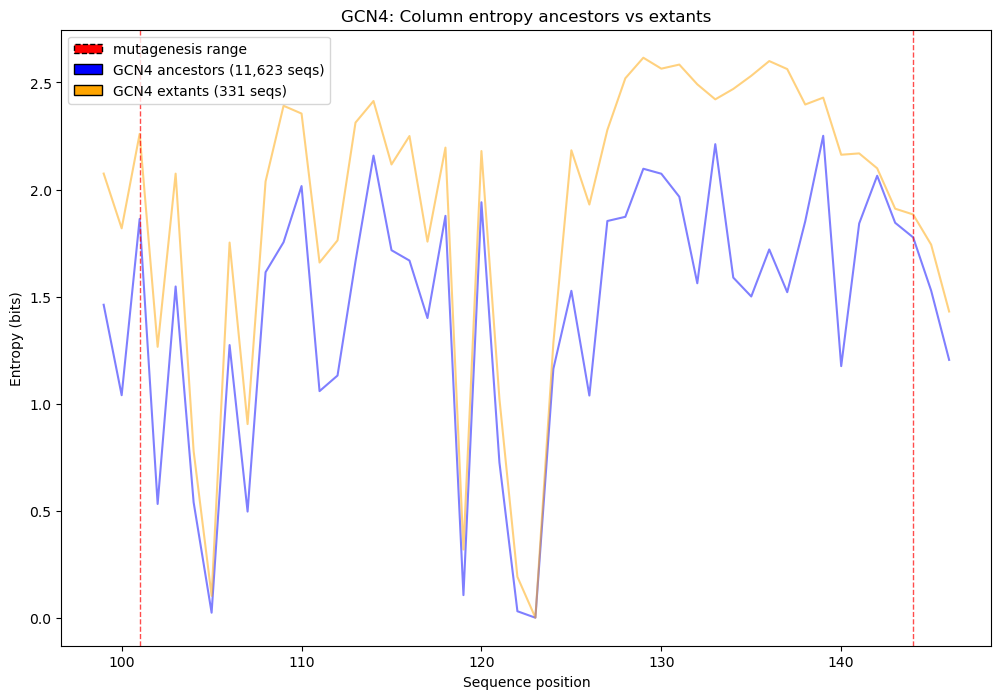

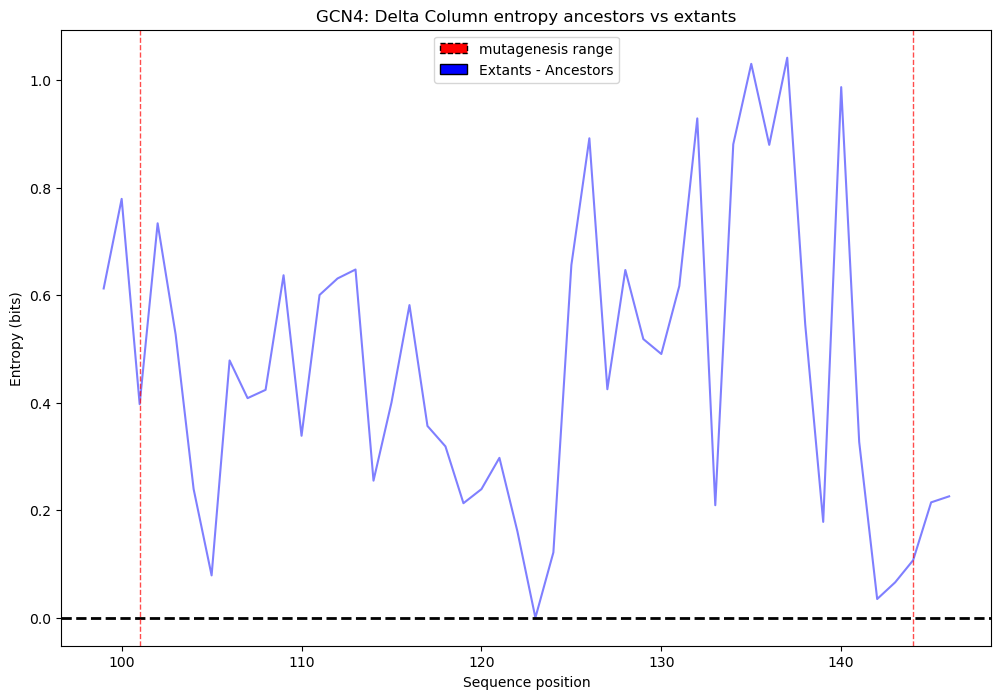

In [140]:

# across entire sequnece 
xticks = range(0, len(gcn4_e_col_entropy))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, gcn4_a_col_entropy, alpha=0.5, color='blue')
plt.plot(xticks, gcn4_e_col_entropy, alpha=0.5, color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis range'),
    Patch(facecolor='blue', edgecolor='black', label='GCN4 ancestors (11,623 seqs)'),
    Patch(facecolor='orange', edgecolor='black', label='GCN4 extants (331 seqs)'),
]

plt.legend(handles=legend_elements,)

mutations = [101, 144]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("GCN4: Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# Delta elbo across entire sequnece 
xticks = range(0, len(gcn4_e_col_entropy))
delta_col_h = gcn4_e_col_entropy - gcn4_a_col_entropy

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=0.5, color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")

plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis range'),
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),
]

plt.legend(handles=legend_elements,)


for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("GCN4: Delta Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# now just across the mutation sites 
xticks = range(99, 147)

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, gcn4_a_col_entropy[99:147], alpha=0.5, label="GCN4 ancestors (12,733 seqs)", color='blue')
plt.plot(xticks, gcn4_e_col_entropy[99:147], alpha=0.5, label="GCN4 extants (2286 seqs)", color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")


legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis range'),
    Patch(facecolor='blue', edgecolor='black', label='GCN4 ancestors (11,623 seqs)'),
    Patch(facecolor='orange', edgecolor='black', label='GCN4 extants (331 seqs)'),
]

#plt.xticks(ticks=xticks, labels=xticks)
plt.legend(handles=legend_elements,)

for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("GCN4: Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# Delta elbo across subset of sequnece 
xticks = range(99, 147)
delta_col_h = (gcn4_e_col_entropy - gcn4_a_col_entropy)[99:147]

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=0.5, label="GCN4 ancestors (12,733 seqs)", color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")

#plt.xticks(ticks=xticks, labels=xticks)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis range'),
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),

]

plt.legend(handles=legend_elements,)

for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("GCN4: Delta Column entropy ancestors vs extants")
plt.show()



##### GCN4 - Wasserstein distance

In [56]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/"
gcn4_a = pd.read_pickle(path + "gcn4_ancestors_no_dupes.pkl")
gcn4_ae = pd.read_pickle(path + "gcn4_ancestors_extants_no_dupes.pkl")
gcn4_e = pd.read_pickle(path + "gcn4_extants_no_dupes.pkl")

In [57]:
gcn4_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/A4_HUMAN_Seuma_2022.csv")
gcn4_variants = gcn4_variants.rename(columns={"mutated_sequence": "sequence", "mutant": "id"})

Sequence weight numpy array created with shape (num_seqs, columns):  (11623, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (331, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (11904, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (14811, 770)
Dist A-E: 1.174627319740789
Dist A-AE: 0.027319806576114106
Dist E-AE: 1.147387000625605
Dist A-V: 6.97560610435255
Dist E-V: 6.940179118598875
Dist AE-V: 6.974742483163051


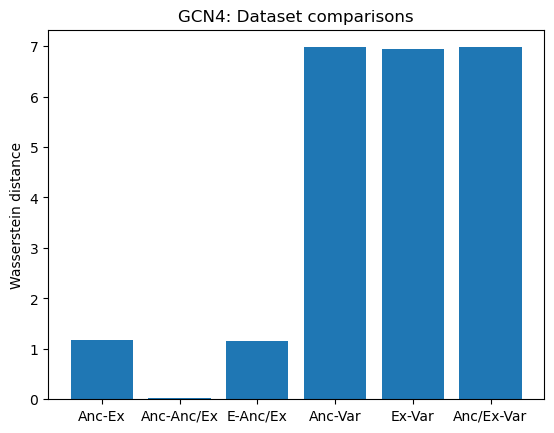

In [59]:
gcn4_a_ppm = stats.calc_position_prob_matrix(gcn4_a)
gcn4_e_ppm = stats.calc_position_prob_matrix(gcn4_e)
gcn4_ae_ppm = stats.calc_position_prob_matrix(gcn4_ae)
gcn4_var_ppm = stats.calc_position_prob_matrix(gcn4_variants)

wd_a_to_e = []
wd_a_to_ae = []
wd_e_to_ae = []
wd_a_to_v = []
wd_e_to_v = []
wd_ae_to_v = []

for i in range(gcn4_a_ppm.shape[1]):
    col_a_i = gcn4_a_ppm[:, i]
    col_e_i = gcn4_e_ppm[:, i]
    col_ae_i = gcn4_ae_ppm[:, i]
    col_v_i = gcn4_var_ppm[:, i]
    
    wd_a_to_e.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)),col_a_i, col_e_i))
    wd_a_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_a_i, col_ae_i))
    wd_e_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_ae_i))

    wd_a_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)), col_a_i, col_v_i))
    wd_e_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_v_i)) 
    wd_ae_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_ae_i, col_v_i))

print(f"Dist A-E: {np.mean(wd_a_to_e)}")
print(f"Dist A-AE: {np.mean(wd_a_to_ae)}")
print(f"Dist E-AE: {np.mean(wd_e_to_ae)}")

print(f"Dist A-V: {np.mean(wd_a_to_v)}")
print(f"Dist E-V: {np.mean(wd_e_to_v)}")
print(f"Dist AE-V: {np.mean(wd_ae_to_v)}")

plt.bar(np.arange(6), [np.mean(wd_a_to_e), np.mean(wd_a_to_ae), np.mean(wd_e_to_ae), np.mean(wd_a_to_v), np.mean(wd_e_to_v), np.mean(wd_ae_to_v)])
plt.title("GCN4: Dataset comparisons")
plt.ylabel("Wasserstein distance")
plt.xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], )
plt.show()